In [56]:
import torch
import numpy as np
import torch.nn as nn
import copy
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import json
from lovely_numpy import lo
import cv2

In [57]:


ROOT_FOLDER = "/datagrid/personal/baljibil"
# ground truth
with open(ROOT_FOLDER + '/repos/scripts/data/mpii_train_gt.json', 'r') as f:
    annot_truth = json.load(f)
# prediction
with open(ROOT_FOLDER + '/repos/scripts/data/coco_pred_mpii.json', 'r') as f:
    annot_pred_coco = json.load(f)

# with open(ROOT_FOLDER + '/repos/scripts/mpii_pred_on_mpii/pred.json', 'r') as f:
#     annot_pred_mpii = json.load(f)
X = list()
y = list()
box_scale = list()
box_center = list()
index2orig = list()

print("len: " , len(annot_truth))
for i in range(len(annot_truth)):
  skip = False
  for joint_vis in annot_truth[i]['joints_vis']:
    if joint_vis == 0:
      skip = True
      break
  if skip:
    continue
  index2orig.append(i)
  X.append(annot_pred_coco['annotations'][i]['joints'])
  y.append(annot_truth[i]['joints'])
  box_scale.append(annot_truth[i]['scale'])
  box_center.append(annot_truth[i]['center'])
X = np.array(X)
y = np.array(y)
box_scale = np.array(box_scale)
box_center = np.array(box_center)
print("X shape: ", X.shape)
print("y shape:", y.shape)
print("box scale:", box_scale.shape)
print("box center:", box_center.shape)


len:  22246
X shape:  (14975, 17, 2)
y shape: (14975, 16, 2)
box scale: (14975,)
box center: (14975, 2)


In [47]:
print(lo(X))
print(lo(y))

array[14975, 17, 2] n=509150 (3.9Mb) x∈[-124.436, 1.934e+03] μ=524.473 σ=321.164
array[14975, 16, 2] n=479200 (3.7Mb) x∈[-23.866, 1.936e+03] μ=533.208 σ=315.845


In [48]:
def center_and_scale(data):
    return (data - box_center[:,np.newaxis,:]) / box_scale[:, np.newaxis, np.newaxis]
def uncenter_and_unscale(data):
    return data * box_scale[:, np.newaxis, np.newaxis] + box_center[:,np.newaxis,:]
def normalize(data):
    data = center_and_scale(data)
    min_val = -150
    max_val = 150
    return ((data - (min_val)) / (max_val - min_val))
def unnormalize(data):
    min_val = -150
    max_val = 150
    data = (data ) * (max_val - min_val) + min_val
  
    return uncenter_and_unscale(data)
X_centered = center_and_scale(X)
y_centered = center_and_scale(y)
X_normalized = normalize(X)
y_normalized = normalize(y)



In [49]:
print(lo(X_normalized[:,:,0]))
print(lo(y_normalized[:,:,0]))

print("...")

print(lo(X_normalized[:,:,1]))
print(lo(y_normalized[:,:,1]))



array[14975, 17] n=254575 (1.9Mb) x∈[0.074, 0.927] μ=0.502 σ=0.086
array[14975, 16] n=239600 (1.8Mb) x∈[-0.883, 1.094] μ=0.500 σ=0.085
...
array[14975, 17] n=254575 (1.9Mb) x∈[0.127, 0.975] μ=0.475 σ=0.173
array[14975, 16] n=239600 (1.8Mb) x∈[-0.533, 1.108] μ=0.500 σ=0.162


array[14975, 17, 2] n=509150 (3.9Mb) x∈[0.074, 0.975] μ=0.488 σ=0.137
array[14975, 16, 2] n=479200 (3.7Mb) x∈[-0.883, 1.108] μ=0.500 σ=0.129


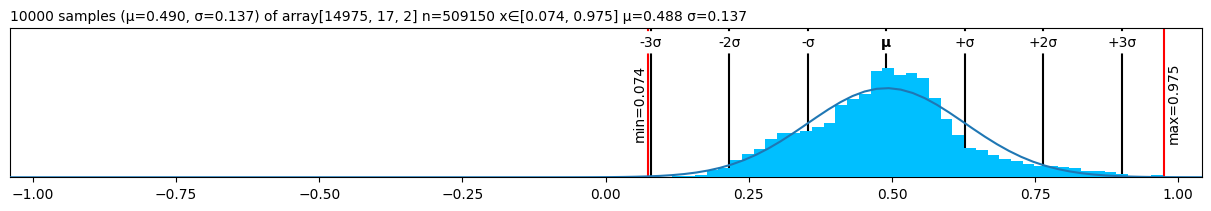

In [50]:
print(lo(X_normalized))
print(lo(y_normalized))
lo(X_normalized).plt

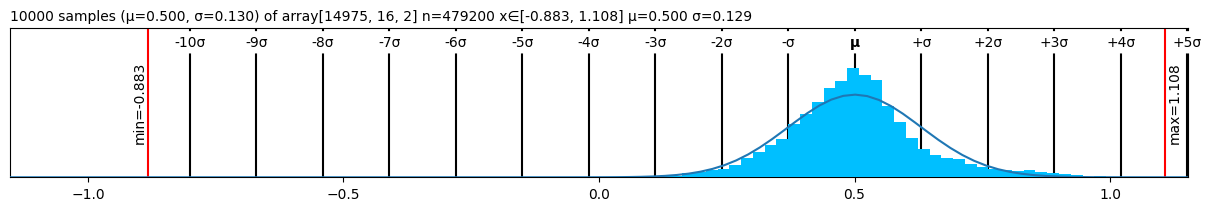

In [51]:
lo(y_normalized).plt


array[14975, 17, 2] n=509150 (3.9Mb) x∈[-0.139, 1.212] μ=0.483 σ=0.206


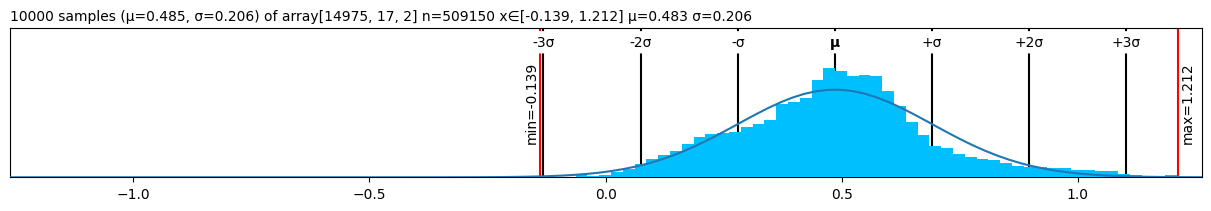

In [66]:
# box_scale = N x 1
# box_center = N x 2
# N x 16 x 2
def normalize1(data):
  # first width & height, but they are the same
  data = copy.deepcopy(data)
  # bbleft point N x 2
  scale_px = 200
  bbox_left = box_center - ((scale_px * box_scale) / 2)[:, np.newaxis]
  bbox_right = box_center + ((scale_px * box_scale) / 2)[:, np.newaxis]

  bbox_width = bbox_right - bbox_left
  data -= bbox_left[:, np.newaxis, :] 
  data /= bbox_width[:, np.newaxis, :]
  return data
  # bbright point
  # return data
X_normalized1 = normalize1(X)
print(lo(X_normalized1))
lo(X_normalized1).plt

array[14975, 16, 2] n=479200 (3.7Mb) x∈[-1.229, 1.260] μ=0.500 σ=0.162


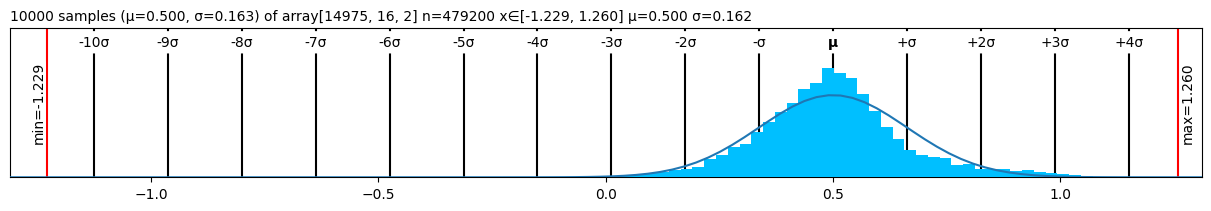

In [62]:
y_normalized1 = normalize1(y)
print(lo(y_normalized1))
lo(y_normalized1).plt

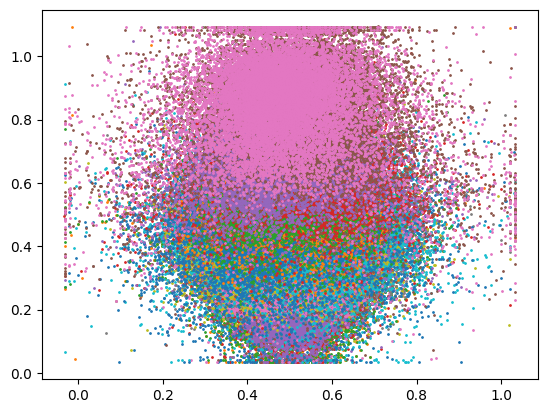

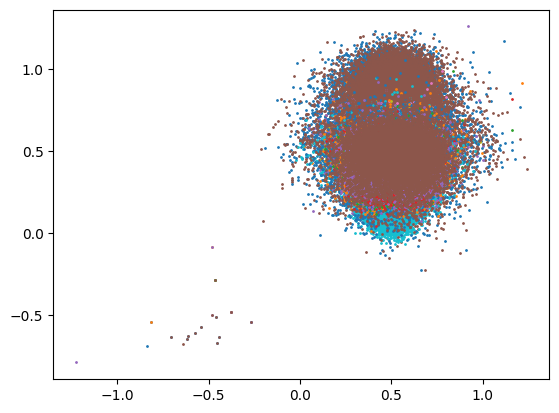

In [63]:
for i in range(17):
  plt.scatter(X_normalized1[:, i, 0],X_normalized1[:, i, 1], s=1)
plt.show()

for i in range(16):
  plt.scatter(y_normalized1[:, i, 0],y_normalized1[:, i, 1], s=1)
plt.show()

## Figure out bounding box

In [11]:
import cv2
from IPython.display import Image, display
from info import MPII_INFO
dataset_info = MPII_INFO()

15722 032456428.jpg
[710.0, 123.0]
1.824631
[[-1.0, -1.0], [794.0, 319.0], [785.0, 216.0], [711.0, 224.0], [701.0, 348.0], [-1.0, -1.0], [748.0, 220.0], [687.0, 50.0], [673.4822, 40.0395], [624.5178, 3.9605], [710.0, 79.0], [782.0, 85.0], [740.0, 24.0], [633.0, 76.0], [624.0, 146.0], [608.0, 161.0]]
bbleft: (527, -59)
bbright: (892, 305)


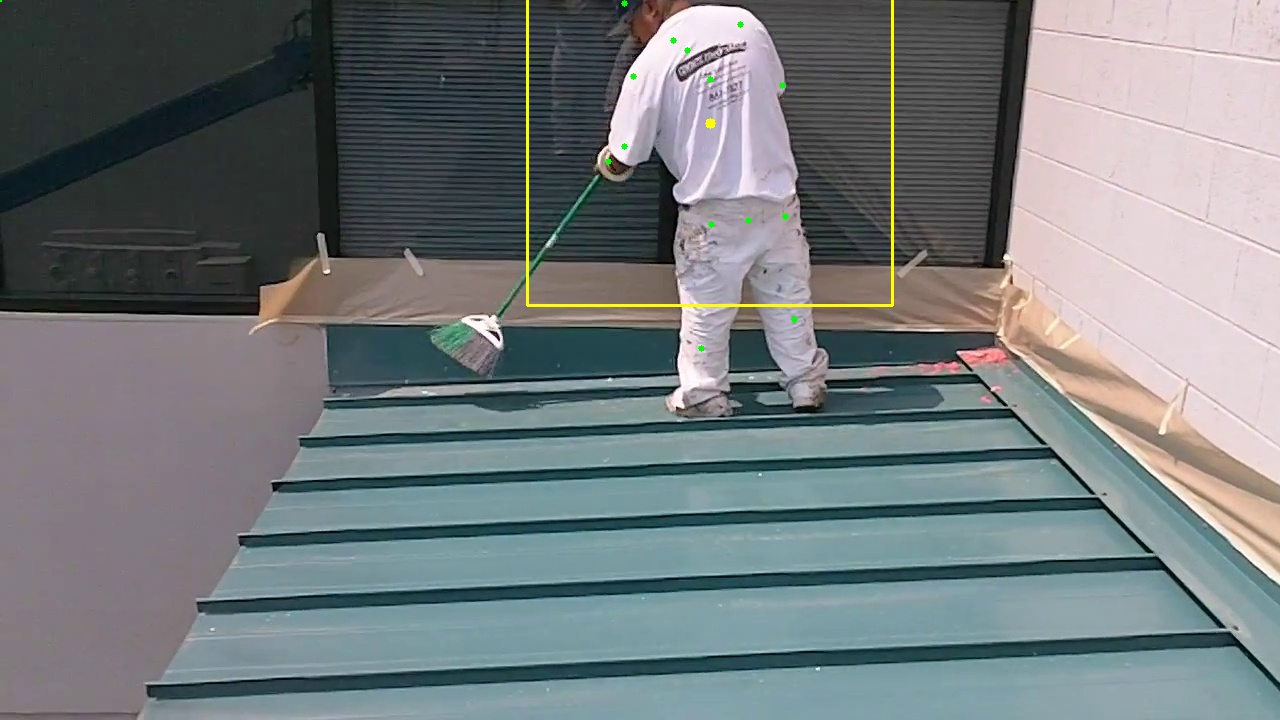

7920 094291271.jpg
[639.0, 340.0]
2.359458
[[708.0, 618.0], [652.0, 503.0], [692.0, 382.0], [723.0, 386.0], [669.0, 504.0], [716.0, 620.0], [708.0, 384.0], [669.0, 237.0], [658.2165, 214.8552], [623.7835, 144.1448], [617.0, 228.0], [632.0, 228.0], [662.0, 238.0], [676.0, 235.0], [679.0, 210.0], [687.0, 182.0]]
bbleft: (403, 104)
bbright: (874, 575)


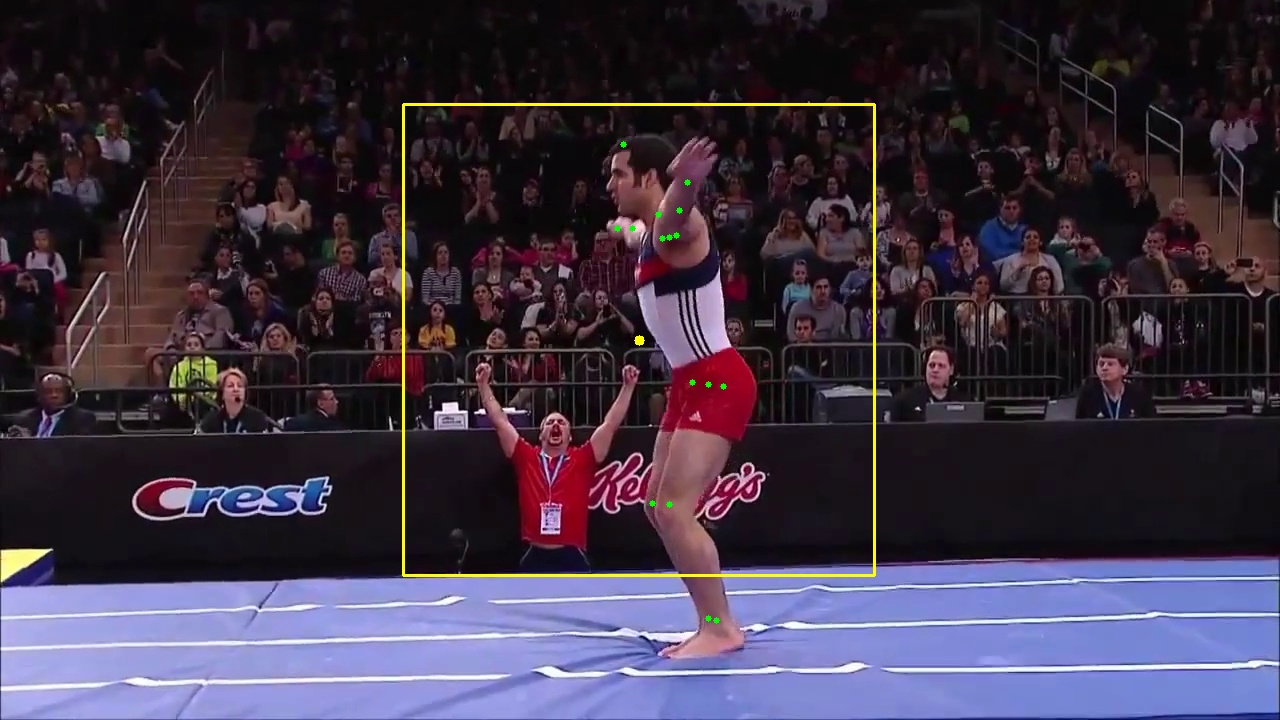

In [23]:

ROOT_FOLDER = "/datagrid/personal/baljibil"
# ground truth
with open(ROOT_FOLDER + '/data/MPII_COCO/annotations/mpii_train.json', 'r') as f:
    annot_truth = json.load(f)
# prediction
with open(ROOT_FOLDER + '/repos/scripts/data/coco_pred_mpii.json', 'r') as f:
    annot_pred_coco = json.load(f)


NUM_IMAGES = 2

# choose image from ground truth
def choose_n_images(gt_json, num_images=10):
  random_numbers = np.random.randint(0, len(gt_json), size=num_images)
  images = list()
  for nums in random_numbers:
     images.append((nums,gt_json[nums]['image']))
  return images

for index, im_path in choose_n_images(annot_truth, NUM_IMAGES):
  print(index, im_path)
  # Load the image
  image = cv2.imread(ROOT_FOLDER + '/data/MPII_COCO/images/' + im_path)

  # Load annotation keypoints from JSON files

  keypoints1 = annot_truth[index]['joints']
  # pred
  print(annot_truth[index]['center'])
  print(annot_truth[index]['scale'])
  center = annot_truth[index]['center']
  scale = annot_truth[index]['scale']
  print(keypoints1)

  for kp in keypoints1:
      x, y = int(kp[0]), int(kp[1])
      cv2.circle(image, (x, y), 3, (0, 255, 0), -1)

  x_bounding_center, y_bounding_center = int(annot_truth[index]['center'][0]), int(annot_truth[index]['center'][1])
  cv2.circle(image, (x_bounding_center, y_bounding_center), 5, (0, 255, 255), -2 )

  scale_px = 200
  bbox_left = (int(center[0] - (scale_px * scale) / 2), int(center[1] - (scale_px * scale) / 2))
  bbox_right = (int(center[0] + (scale_px * scale) / 2), int(center[1] + (scale_px * scale) / 2))
  print("bbleft:", bbox_left)
  print("bbright:", bbox_right)
  cv2.rectangle(image, bbox_left, bbox_right, (0,255,255), 2)
  # Split the image horizontally
#   image1 = image[:, :image.shape[1]//2]
#   image2 = image[:, image.shape[1]//2:]

  # Display the annotated images side by side
  cv2.imwrite(f'tm_results1/image{index}.jpg', image)

  display(Image(filename=f'tm_results1/image{index}.jpg'))


In [ ]:
import scipy.io
mat = scipy.io.loadmat('/datagrid/personal/baljibil/data/MPII_COCO/annotations/mpii_gt_val.mat')
